# Trabalho Prático 2

Este notebook aborda o projeto de Machine Learning para construir um sistema de intervenção para estudantes, baseado no dataset UCI Student Performance.

**Objetivo:** Desenvolver um pipeline de machine learning capaz de prever se um estudante passará no exame final (`passed` = 'yes'), permitindo a identificação de alunos que necessitam de atenção e suporte extra.


**Etapas:**
1.  **Setup e Carregamento de Dados:** Importar bibliotecas e carregar o dataset.
2.  **Exploração de Dados (EDA):** Análise inicial para compreender as características do dataset, com foco em visualizações.
3.  **Pré-processamento e Engenharia de Features:** Preparação dos dados para modelagem, incluindo codificação, escalonamento e análise de outliers com PCA.
4.  **Modelação:** Treino e avaliação inicial de modelos de aprendizagem supervisionada.
5.  **Otimização e Avaliação Avançada:** Otimização de hiperparâmetros, tratamento de desbalanceamento de classes e avaliação detalhada.
6.  **Interpretação e Conclusões:** Análise dos resultados, importância das features e conclusões finais.
7.  **(Opcional) Análise de IA Responsável:** Investigação de potenciais vieses.
8.  **(Opcional) Deployment:** Sugestões para deployment.


# 1. Setup e Carregamento de Dados
Nesta etapa, importamos as bibliotecas necessárias e carregamos o dataset

In [73]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Modelos adicionais
from sklearn.svm import SVC

# Métricas de Avaliação
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, roc_curve,
                           classification_report, ConfusionMatrixDisplay)
from sklearn.model_selection import learning_curve  # Corrected import

# Balanceamento de Classes
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline do imblearn
from imblearn.over_sampling import SMOTE

import warnings

# Configurações
%matplotlib inline
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print('Bibliotecas importadas com sucesso!')


Bibliotecas importadas com sucesso!


## Dataset

In [74]:
data_path = 'student-data.csv'
df = pd.read_csv(data_path)

le = LabelEncoder()
df['passed_numeric'] = le.fit_transform(df['passed'])
# Guardar o mapeamento para referência
target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Mapeamento da variável alvo 'passed': {target_mapping}")

print("\n--- Primeiras 5 linhas do Dataset ---")
display(df.head())

print(f"\nDimensões do Dataset: {df.shape[0]} linhas e {df.shape[1]} colunas")

Mapeamento da variável alvo 'passed': {'no': np.int64(0), 'yes': np.int64(1)}

--- Primeiras 5 linhas do Dataset ---


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed,passed_numeric
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,no,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,no,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,yes,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,yes,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,yes,1



Dimensões do Dataset: 395 linhas e 32 colunas


# 2. Exploração de Dados
Nesta secção, realizamos uma análise exploratória detalhada para entender a estrutura, tipos de dados, distribuições e relações entre as variáveis.


## Estatisticas Descritivas Basicas

In [75]:
# Informações gerais sobre o dataset
print('\n--- Informações Gerais ---')
df.info()

print('\n--- Estatísticas Descritivas (Numéricas) ---')
display(df.describe(include=np.number))

print('\n--- Estatísticas Descritivas (Categóricas) ---')
display(df.describe(include='object'))

print('\n--- Valores em Falta ---')
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].to_markdown() if missing_values.sum() > 0 else 'Nenhum valor em falta encontrado.')

print('\n--- Distribuição da Variável Alvo (passed) ---')
fig = px.pie(df, names='passed', title='Distribuição da Variável Alvo (passed)',
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.show()
print(df['passed'].value_counts(normalize=True).to_markdown())


--- Informações Gerais ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   school          395 non-null    object
 1   sex             395 non-null    object
 2   age             395 non-null    int64 
 3   address         395 non-null    object
 4   famsize         395 non-null    object
 5   Pstatus         395 non-null    object
 6   Medu            395 non-null    int64 
 7   Fedu            395 non-null    int64 
 8   Mjob            395 non-null    object
 9   Fjob            395 non-null    object
 10  reason          395 non-null    object
 11  guardian        395 non-null    object
 12  traveltime      395 non-null    int64 
 13  studytime       395 non-null    int64 
 14  failures        395 non-null    int64 
 15  schoolsup       395 non-null    object
 16  famsup          395 non-null    object
 17  paid            395 non-nu

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,passed_numeric
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.670886
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.470487
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000



--- Estatísticas Descritivas (Categóricas) ---


,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,passed
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no,yes
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263,265



--- Valores em Falta ---
Nenhum valor em falta encontrado.

--- Distribuição da Variável Alvo (passed) ---


| passed   |   proportion |
|:---------|-------------:|
| yes      |     0.670886 |
| no       |     0.329114 |


--- Análise de Variáveis Categóricas vs. Alvo ---


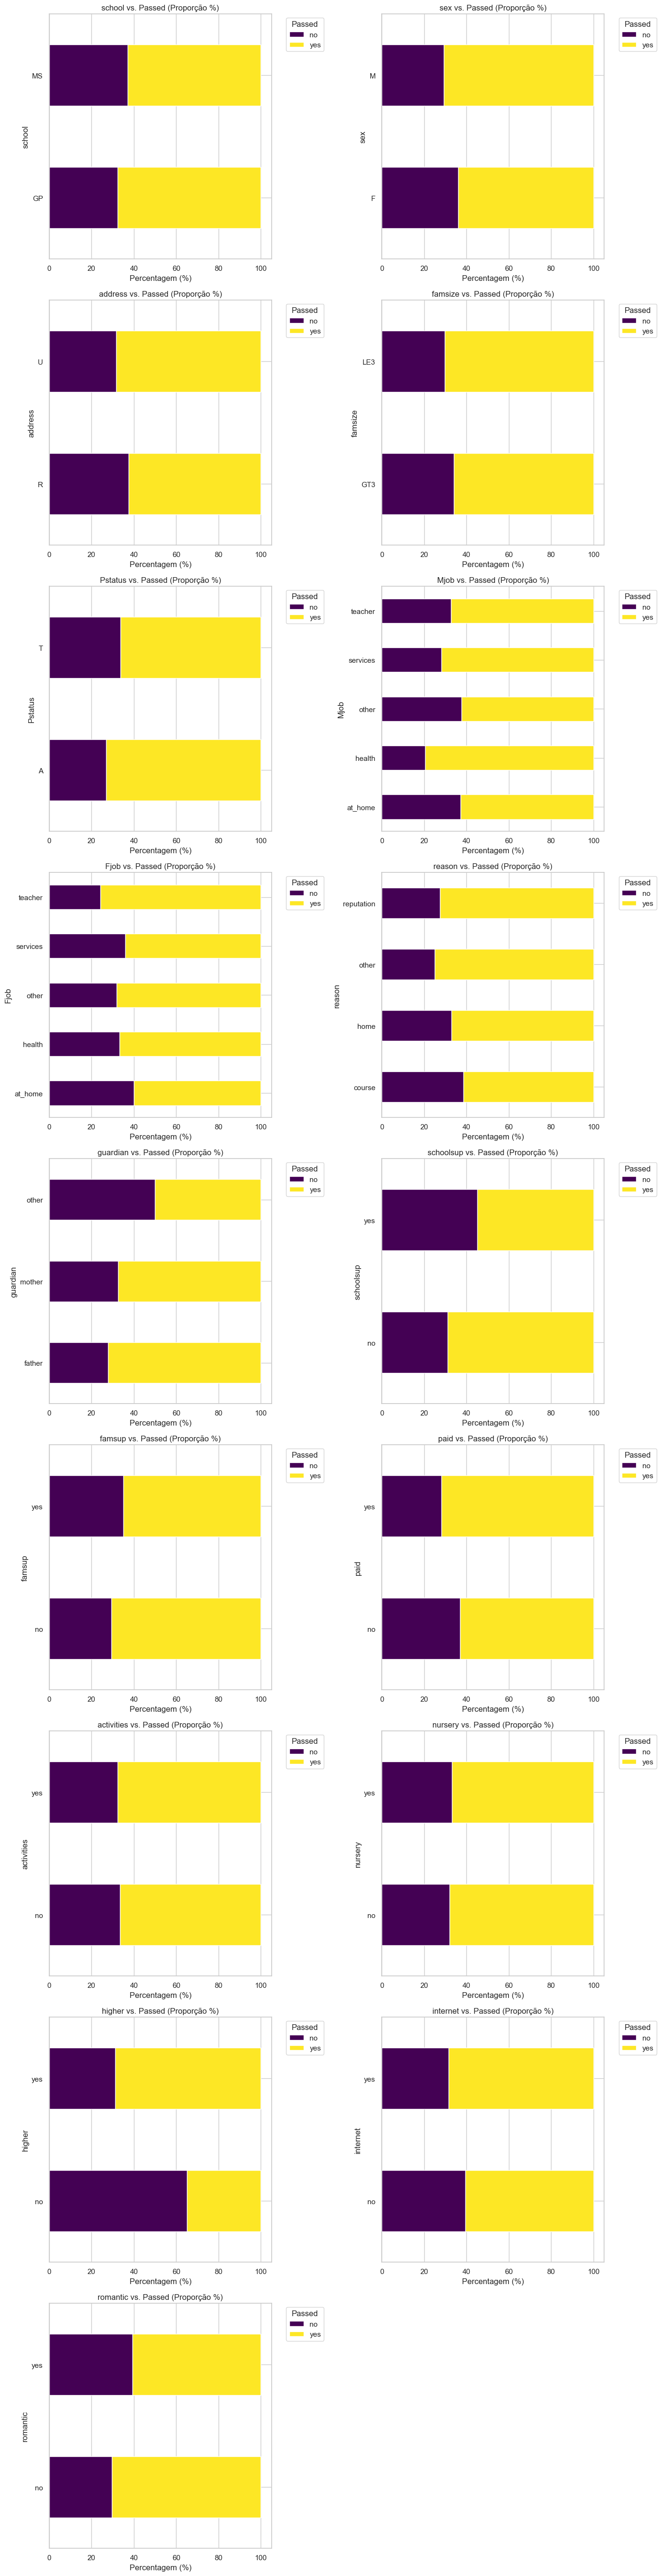

In [76]:
print('--- Análise de Variáveis Categóricas vs. Alvo ---')
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Remover 'passed' da lista de features a analisar
if 'passed' in categorical_features:
    categorical_features.remove('passed')

# Visualizar a distribuição das variáveis categóricas em relação ao alvo
if categorical_features:
    num_plots = len(categorical_features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols

    plt.figure(figsize=(14, 6 * num_rows))
    for i, col in enumerate(categorical_features):
        plt.subplot(num_rows, num_cols, i + 1)
        # Calcular proporções para o gráfico de barras empilhadas 100%
        prop_df = df.groupby([col, 'passed']).size().unstack().fillna(0)
        prop_df = prop_df.apply(lambda x: x*100/sum(x), axis=1)
        prop_df.plot(kind='barh', stacked=True, ax=plt.gca(), colormap='viridis')
        plt.title(f'{col} vs. Passed (Proporção %)')
        plt.xlabel('Percentagem (%)')
        plt.ylabel(col)
        plt.legend(title='Passed', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print('Nenhuma variável categórica (excluindo alvo) para visualizar.')

In [77]:
# Importar bibliotecas
from scipy.stats import chi2_contingency

categorical_columns = X_train.select_dtypes(include=['object']).columns

chi2_results = {}

for col in categorical_columns:
    contingency_table = pd.crosstab(X_train[col], y_train)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    chi2_results[col] = {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof
    }

significant_vars = pd.DataFrame({
    'Variável': list(chi2_results.keys()),
    'Chi-quadrado': [chi2_results[var]['chi2'] for var in chi2_results],
    'p-valor': [chi2_results[var]['p_value'] for var in chi2_results]
}).sort_values('p-valor')


print("Variáveis categóricas ordenadas por significância estatística:")
print(significant_vars)


Variáveis categóricas ordenadas por significância estatística:
      Variável  Chi-quadrado   p-valor
14      higher      9.856492  0.001692
9    schoolsup      3.412272  0.064713
8     guardian      4.331405  0.114669
11        paid      2.108576  0.146476
1          sex      1.647356  0.199319
7       reason      3.219966  0.358938
16    romantic      0.747310  0.387329
6         Fjob      4.051660  0.399060
5         Mjob      3.950552  0.412739
4      Pstatus      0.539439  0.462665
10      famsup      0.452115  0.501332
0       school      0.437931  0.508123
3      famsize      0.397593  0.528335
2      address      0.105355  0.745495
12  activities      0.067043  0.795692
13     nursery      0.000316  0.985810
15    internet      0.000000  1.000000


--- Análise de Variáveis Numéricas vs. Alvo ---


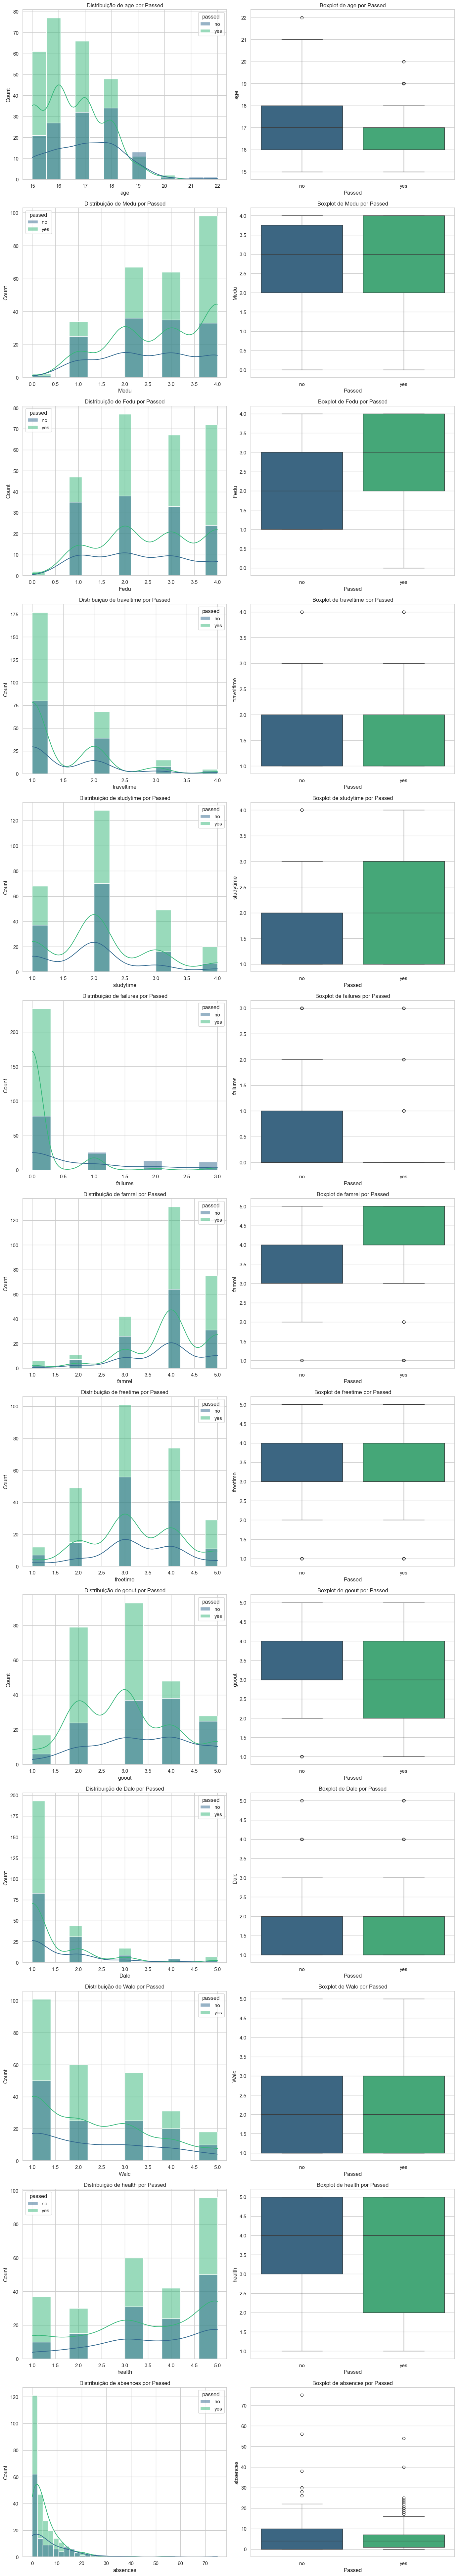

In [78]:
print('--- Análise de Variáveis Numéricas vs. Alvo ---')
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

if 'passed_numeric' in numeric_features:
    numeric_features.remove('passed_numeric')

if numeric_features:
    num_plots = len(numeric_features)
    num_cols = 2
    num_rows = num_plots 

    plt.figure(figsize=(14, 6 * num_rows))
    for i, col in enumerate(numeric_features):
        # Histograma
        plt.subplot(num_rows, num_cols, 2*i + 1)
        sns.histplot(data=df, x=col, hue='passed', kde=True, palette='viridis')
        plt.title(f'Distribuição de {col} por Passed')

        # Boxplot
        plt.subplot(num_rows, num_cols, 2*i + 2)
        sns.boxplot(data=df, y=col, x='passed', palette='viridis')
        plt.title(f'Boxplot de {col} por Passed')
        plt.xlabel('Passed')

    plt.tight_layout()
    plt.show()
else:
    print('Nenhuma variável numérica para visualizar.')

In [79]:
print('--- Matriz de Correlação (Variáveis Numéricas) ---')

# Incluir a variável alvo numérica para ver correlações com ela
df_numeric_with_target = df[numeric_features + ['passed_numeric']]

corr_matrix = df_numeric_with_target.corr()

# Usar Plotly para heatmap interativo
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                color_continuous_scale='Viridis',
                title='Matriz de Correlação de Pearson (Features Numéricas + Alvo)')
fig.show()

# Mostrar correlações com a variável alvo
print("\n--- Correlações com 'passed_numeric' ---")
corr_target = corr_matrix['passed_numeric'].sort_values(ascending=False)
print(corr_target.drop('passed_numeric').to_markdown())  # Excluir auto-correlação

--- Matriz de Correlação (Variáveis Numéricas) ---



--- Correlações com 'passed_numeric' ---
|            |   passed_numeric |
|:-----------|-----------------:|
| Medu       |        0.115396  |
| Fedu       |        0.108057  |
| studytime  |        0.0746125 |
| famrel     |        0.0466834 |
| freetime   |       -0.0183214 |
| Walc       |       -0.0299569 |
| traveltime |       -0.0444465 |
| Dalc       |       -0.0573428 |
| health     |       -0.0656675 |
| absences   |       -0.0922437 |
| age        |       -0.179645  |
| goout      |       -0.183399  |
| failures   |       -0.337731  |


# 3. Pré-processamento e Tratamento de Features

Nesta fase, preparamos os dados para a modelagem:
*   **Codificação:** Transformar variáveis categóricas em numéricas (One-Hot Encoding).
*   **Normalização:** Normalizar variáveis numéricas (StandardScaler).
*   **Análise de Outliers (PCA):** Investigar outliers usando Análise de Componentes Principais(PCA).
*   **Divisão Treino/Teste:** Separar os dados para treino e avaliação final.

In [80]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()
target = 'passed_numeric'
original_target_cat = 'passed'

if target in numeric_features:
    numeric_features.remove(target)
if original_target_cat in categorical_features:
    categorical_features.remove(original_target_cat)

print(f'Features Numéricas para Pré-processamento: {numeric_features}')
print(f'Features Categóricas para Pré-processamento: {categorical_features}')

# Criar o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)],  
    remainder='passthrough' 
)

X = df.drop([original_target_cat, target], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Dimensões Originais:')
# print(f'Nomes das Features Processadas: {feature_names_processed}') # Descomentar para ver nomes

Features Numéricas para Pré-processamento: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Features Categóricas para Pré-processamento: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Dimensões Originais:


Número de outliers por coluna:
 age                1
Medu               0
Fedu               2
traveltime         8
studytime         27
failures          83
famrel            26
freetime          19
goout              0
Dalc              18
Walc               0
health             0
absences          15
passed_numeric     0
dtype: int64
Número de outliers severos por coluna:
 age                0
Medu               0
Fedu               0
traveltime         0
studytime          0
failures          83
famrel             0
freetime           0
goout              0
Dalc               0
Walc               0
health             0
absences           5
passed_numeric     0
dtype: int64


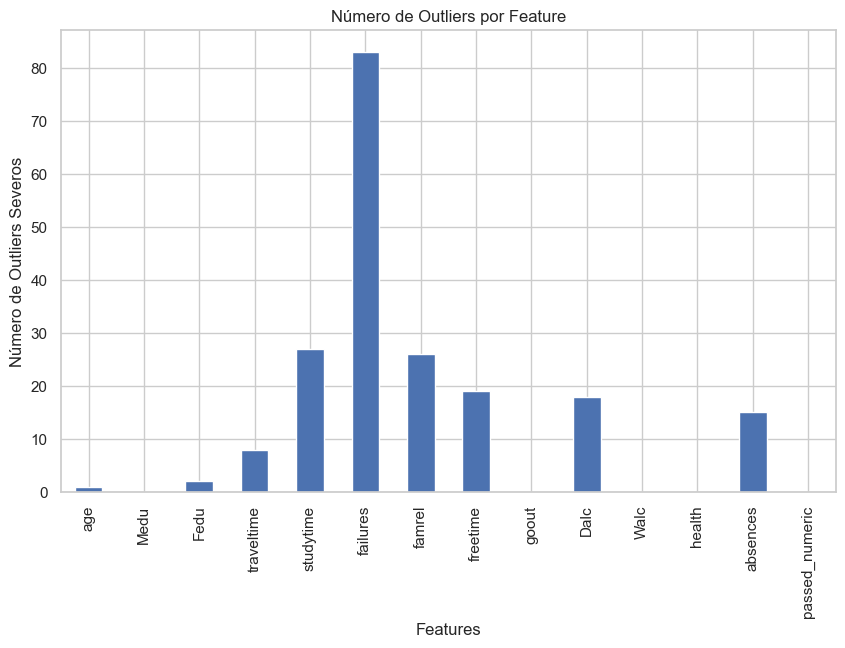

In [81]:
numeric_df = df.select_dtypes(include=['number'])
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_df = df[numeric_cols]

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((numeric_df < lower_bound) | (numeric_df > upper_bound))

outliers_count = outliers.sum()
print("Número de outliers por coluna:\n", outliers_count)

lower_bound_severe = Q1 - 3 * IQR
upper_bound_severe = Q3 + 3 * IQR

outliers_severe = ((numeric_df < lower_bound_severe) | (numeric_df > upper_bound_severe))

outliers_severe_count = outliers_severe.sum()
print("Número de outliers severos por coluna:\n", outliers_severe_count)

outliers_count.plot(kind='bar', figsize=(10, 6), title='Número de Outliers por Feature')
plt.xlabel('Features')
plt.ylabel('Número de Outliers Severos')
plt.show()

In [82]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)

X_train_processed = preprocessor.fit_transform(X_train)

X_train_pca_2d = pca_2d.fit_transform(X_train_processed)

distances_2d = np.sqrt(np.sum(X_train_pca_2d**2, axis=1))
outlier_threshold_2d = np.percentile(distances_2d, 98)  
outliers_pca_indices_train = X_train.index[distances_2d > outlier_threshold_2d]

print(f'Threshold de distância (Percentil 98 no espaço 2D - Treino): {outlier_threshold_2d:.2f}')
print(f'Número de outliers potenciais identificados no treino: {len(outliers_pca_indices_train)}')
if not outliers_pca_indices_train.empty:
    print(f'Índices dos outliers potenciais no treino: {outliers_pca_indices_train.tolist()}')
else:
    print('Nenhum outlier potencial identificado no treino.')

fig = px.scatter(x=X_train_pca_2d[:, 0], y=X_train_pca_2d[:, 1], color=y_train.astype(str),
                 labels={'color': 'Passed'}, title='PCA (2 Componentes) com Outliers Potenciais - Treino',
                 hover_name=X_train.index)
fig.add_trace(go.Scatter(x=X_train_pca_2d[distances_2d > outlier_threshold_2d, 0],
                         y=X_train_pca_2d[distances_2d > outlier_threshold_2d, 1],
                         mode='markers', marker=dict(color='red', size=10, symbol='x'),
                         name='Outlier Potencial', hoverinfo='text',
                         hovertext=[f'Index: {i}' for i in outliers_pca_indices_train]))
fig.update_layout(xaxis_title='Componente Principal 1', yaxis_title='Componente Principal 2')
fig.show()

print('Decisão: Manter outliers para a modelagem inicial.')


Threshold de distância (Percentil 98 no espaço 2D - Treino): 4.72
Número de outliers potenciais identificados no treino: 6
Índices dos outliers potenciais no treino: [100, 247, 61, 29, 392, 350]


Decisão: Manter outliers para a modelagem inicial.


# Algoritmos

Nesta secção, treinamos e avaliamos o desempenho inicial de diferentes modelos de classificação usando validação cruzada no conjunto de treino pré-processado.

Modelos a explorar:
*   Regressão Logística
*   K-Nearest Neighbors (KNN)
*   Árvore de Decisão
*   Random Forest
*   Gradient Boosting
*   Support Vector Machine (SVM)
*   Rede Neuronal (MLP Classifier)

In [83]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42), 
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=500, early_stopping=True) 
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_cv = {}

print("--- Avaliação Inicial com Validação Cruzada Estratificada (Treino) ---")

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models.items():
    print(f'A avaliar {name}...')
    metrics_scores = {metric: cross_val_score(model, X_train_processed, y_train, cv=skf, scoring=metric) for metric in scoring_metrics}
    results_cv[name] = {metric: scores.mean() for metric, scores in metrics_scores.items()}
    print(f'{name} - Acurácia Média: {results_cv[name]["accuracy"]:.4f}')

results_cv_df = pd.DataFrame(results_cv).T
print('\n--- Resultados Médios da Validação Cruzada (Treino) ---')
display(results_cv_df.style.highlight_max(axis=0, color='lightgreen'))

fig = px.bar(results_cv_df.reset_index().melt(id_vars='index', var_name='Métrica', value_name='Score'),
             x='index', y='Score', color='Métrica', barmode='group',
             title='Comparação de Métricas dos Modelos (Validação Cruzada no Treino)',
             labels={'index': 'Modelo'})
fig.show()

--- Avaliação Inicial com Validação Cruzada Estratificada (Treino) ---
A avaliar Logistic Regression...
Logistic Regression - Acurácia Média: 0.6812
A avaliar KNN...
KNN - Acurácia Média: 0.6558
A avaliar Decision Tree...
Decision Tree - Acurácia Média: 0.6231
A avaliar Random Forest...
Random Forest - Acurácia Média: 0.7176
A avaliar Gradient Boosting...
Gradient Boosting - Acurácia Média: 0.6886
A avaliar SVM...
SVM - Acurácia Média: 0.7248
A avaliar MLP Classifier...
MLP Classifier - Acurácia Média: 0.6193

--- Resultados Médios da Validação Cruzada (Treino) ---


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.681169,0.732975,0.827027,0.776068,0.664612
KNN,0.655844,0.699999,0.854054,0.768091,0.581634
Decision Tree,0.623117,0.730820,0.691892,0.709198,0.587466
Random Forest,0.717597,0.731288,0.913514,0.812180,0.700435
Gradient Boosting,0.688636,0.736738,0.832432,0.780198,0.679311
SVM,0.724805,0.726920,0.945946,0.821753,0.667931
MLP Classifier,0.619286,0.674407,0.832432,0.736662,0.523107


## 5. Otimização e Avaliação Avançada

Com base nos resultados iniciais, selecionamos alguns modelos promissores para otimização de hiperparâmetros e avaliamos o impacto do tratamento do desbalanceamento de classes usando SMOTE.

*   **Otimização de Hiperparâmetros:** Usar GridSearchCV para encontrar os melhores parâmetros.
*   **Tratamento de Desbalanceamento (SMOTE):** Aplicar SMOTE no conjunto de treino para lidar com a ligeira predominância da classe 'yes'.
*   **Avaliação Final no Teste:** Avaliar os modelos otimizados (com e sem SMOTE) no conjunto de teste.

In [84]:
print('--- Otimização de Hiperparâmetros (Exemplo: Random Forest) ---')

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid_rf, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_rf.fit(X_train_processed, y_train)

print(f"Melhores Parâmetros para Random Forest (AUC): {grid_search_rf.best_params_}")
print(f"Melhor Score ROC AUC (CV): {grid_search_rf.best_score_:.4f}")

best_rf = grid_search_rf.best_estimator_

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'] 
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000),
                              param_grid_lr, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train_processed, y_train)
print(f"Melhores Parâmetros para Logistic Regression (AUC): {grid_search_lr.best_params_}")
print(f"Melhor Score ROC AUC (CV): {grid_search_lr.best_score_:.4f}")
best_lr = grid_search_lr.best_estimator_


--- Otimização de Hiperparâmetros (Exemplo: Random Forest) ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores Parâmetros para Random Forest (AUC): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Melhor Score ROC AUC (CV): 0.7217
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores Parâmetros para Logistic Regression (AUC): {'C': 0.1, 'solver': 'liblinear'}
Melhor Score ROC AUC (CV): 0.6867


In [85]:
print('--- Avaliação com Tratamento de Desbalanceamento (SMOTE) ---')

optimized_models = {
    'Logistic Regression (Otimizado)': best_lr, 
    'Random Forest (Otimizado)': best_rf, 
    'Gradient Boosting (Padrão)': GradientBoostingClassifier(random_state=42)
}

results_smote = {}

print("A avaliar modelos com SMOTE...")
for name, model in optimized_models.items():
    pipeline_smote = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model) 
    ])

    cv_scores_smote = cross_val_score(pipeline_smote, X_train_processed, y_train, cv=skf, scoring='roc_auc')
    results_smote[name + ' + SMOTE'] = cv_scores_smote.mean()
    print(f'{name} + SMOTE - ROC AUC Médio (CV): {cv_scores_smote.mean():.4f}')

print("\nComparação ROC AUC (CV) com e sem SMOTE:")
comparison_df = pd.DataFrame({
    'Sem SMOTE (Otimizado/Padrão)': {
        'Logistic Regression (Otimizado)': grid_search_lr.best_score_,
        'Random Forest (Otimizado)': grid_search_rf.best_score_,
        'Gradient Boosting (Padrão)': results_cv['Gradient Boosting']['roc_auc'] 
    },
    'Com SMOTE': {name: score for name, score in results_smote.items()}
})

display(comparison_df)

--- Avaliação com Tratamento de Desbalanceamento (SMOTE) ---
A avaliar modelos com SMOTE...
Logistic Regression (Otimizado) + SMOTE - ROC AUC Médio (CV): 0.6808
Random Forest (Otimizado) + SMOTE - ROC AUC Médio (CV): 0.6856
Gradient Boosting (Padrão) + SMOTE - ROC AUC Médio (CV): 0.6597

Comparação ROC AUC (CV) com e sem SMOTE:


,Sem SMOTE (Otimizado/Padrão),Com SMOTE
Logistic Regression (Otimizado),0.686708,NaN
Random Forest (Otimizado),0.721732,NaN
Gradient Boosting (Padrão),0.679311,NaN
Logistic Regression (Otimizado) + SMOTE,NaN,0.680844
Random Forest (Otimizado) + SMOTE,NaN,0.685570
Gradient Boosting (Padrão) + SMOTE,NaN,0.659744


--- Logistic Regression (Otimizado) (Teste) ---
              precision    recall  f1-score   support

          no       0.59      0.33      0.43        39
         yes       0.73      0.89      0.80        80

    accuracy                           0.71       119
   macro avg       0.66      0.61      0.61       119
weighted avg       0.69      0.71      0.68       119

ROC AUC: 0.6160


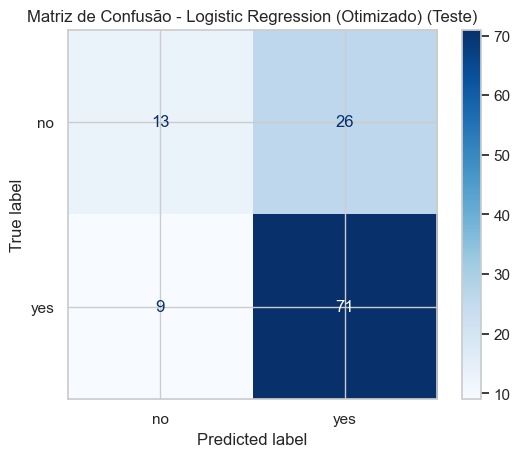

--- Random Forest (Otimizado) (Teste) ---
              precision    recall  f1-score   support

          no       0.50      0.21      0.29        39
         yes       0.70      0.90      0.79        80

    accuracy                           0.67       119
   macro avg       0.60      0.55      0.54       119
weighted avg       0.63      0.67      0.62       119

ROC AUC: 0.6196


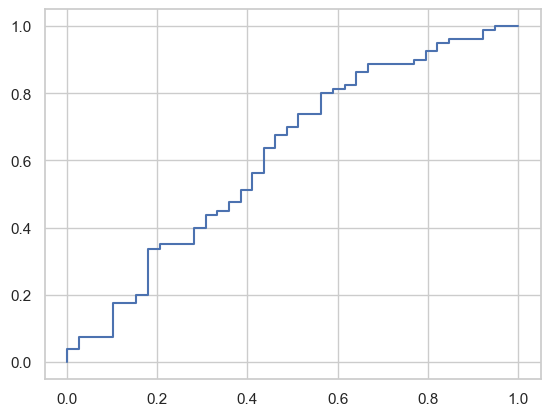

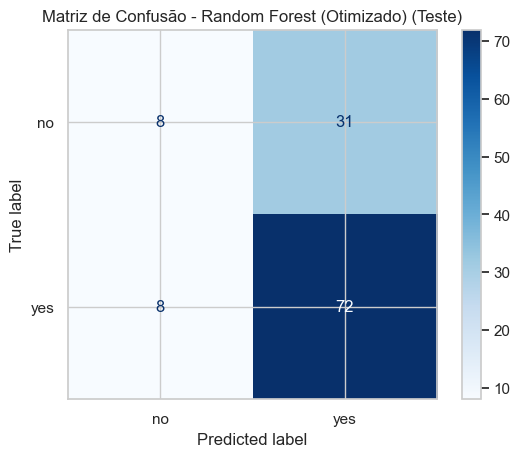

--- Gradient Boosting (Padrão) (Teste) ---
              precision    recall  f1-score   support

          no       0.50      0.38      0.43        39
         yes       0.73      0.81      0.77        80

    accuracy                           0.67       119
   macro avg       0.62      0.60      0.60       119
weighted avg       0.65      0.67      0.66       119

ROC AUC: 0.5949


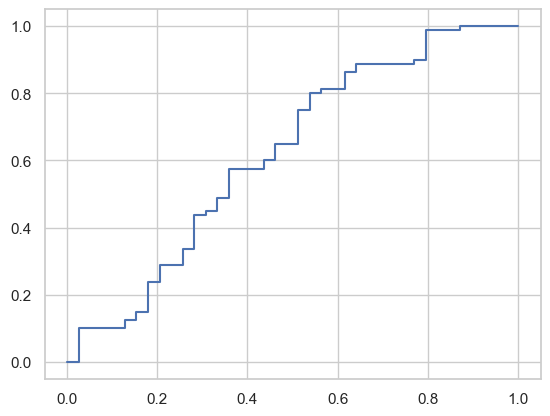

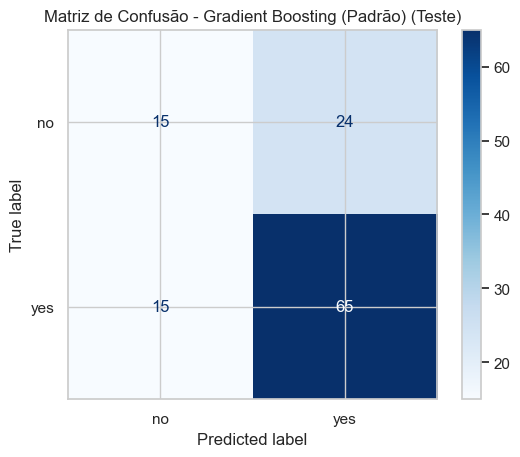

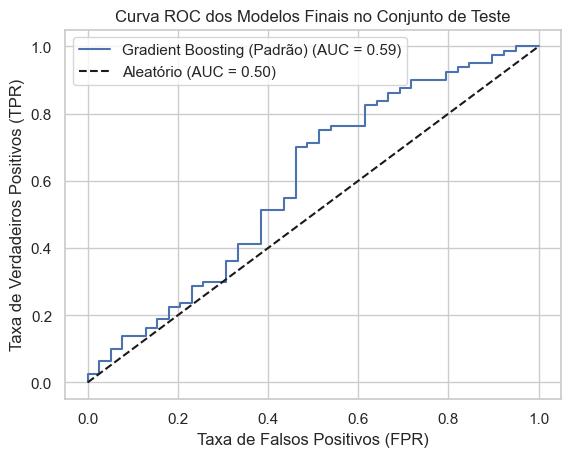

--- Tabela Comparativa dos Resultados Finais no Teste ---


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression (Otimizado),0.705882,0.731959,0.887500,0.802260,0.616026
Random Forest (Otimizado),0.672269,0.699029,0.900000,0.786885,0.619551
Gradient Boosting (Padrão),0.672269,0.730337,0.812500,0.769231,0.594872


In [86]:
final_models_to_test = {
    'Logistic Regression (Otimizado)': best_lr,
    'Random Forest (Otimizado)': best_rf,
    'Gradient Boosting (Padrão)': GradientBoostingClassifier(random_state=42)
}

final_test_results = {}

X_test_processed = preprocessor.transform(X_test)

for name, model in final_models_to_test.items():
    model.fit(X_train_processed, y_train)

    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    final_test_results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'ROC AUC': roc_auc}

    print(f'--- {name} (Teste) ---')
    print(classification_report(y_test, y_pred, target_names=['no', 'yes']))
    print(f'ROC AUC: {roc_auc:.4f}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_mapping.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão - {name} (Teste)')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC dos Modelos Finais no Conjunto de Teste')
plt.legend()
plt.grid(True)
plt.show()

final_test_results_df = pd.DataFrame(final_test_results).T
print('--- Tabela Comparativa dos Resultados Finais no Teste ---')
display(final_test_results_df.style.highlight_max(axis=0, color='lightcoral'))

## 6. Necessidades Especiais

In [87]:
from sklearn.ensemble import IsolationForest

special_needs_vars = [
    'studytime', 'failures', 'absences', 'health', 'Medu', 'Fedu', 'famrel'
]

X_train_special = X_train.copy()

binary_vars = ['schoolsup', 'famsup', 'paid']
for var in binary_vars:
    if var in X_train.columns:
        X_train_special[f'{var}_numeric'] = X_train[var].map({'yes': 1, 'no': 0})
        special_needs_vars.append(f'{var}_numeric')

X_special = X_train_special[special_needs_vars].copy()
scaler = StandardScaler()
X_special_scaled = scaler.fit_transform(X_special)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
train_anomaly_scores = iso_forest.fit_predict(X_special_scaled)
train_anomalies = X_train.index[train_anomaly_scores == -1]  

print(f"Número de alunos identificados como potenciais casos especiais: {len(train_anomalies)}")
print(f"Índices dos alunos com potenciais necessidades especiais: {train_anomalies.tolist()}")



Número de alunos identificados como potenciais casos especiais: 14
Índices dos alunos com potenciais necessidades especiais: [309, 278, 150, 216, 206, 25, 247, 140, 76, 280, 127, 95, 74, 350]


In [88]:
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_special['cluster'] = kmeans.fit_predict(X_special_scaled)

available_vars = [var for var in special_needs_vars if var in X_train_special.columns]

if 'passed_numeric' in X_train.columns:
    X_train_special['passed_numeric'] = X_train['passed_numeric']
    available_vars.append('passed_numeric')
elif 'passed_numeric' in df.columns: 
    X_train_special['passed_numeric'] = df.loc[X_train.index, 'passed_numeric']
    available_vars.append('passed_numeric')

cluster_stats = X_train_special.groupby('cluster')[available_vars].mean()
print("\nCaracterísticas por cluster:")
print(cluster_stats)

if 'passed_numeric' in available_vars:
    approval_by_cluster = X_train_special.groupby('cluster')['passed_numeric'].mean() * 100
    worst_cluster = approval_by_cluster.idxmin()
    print(f"\nCluster {worst_cluster} tem a menor taxa de aprovação: {approval_by_cluster[worst_cluster]:.2f}%")
    print("Este cluster pode representar alunos com necessidades especiais.")

    special_needs_candidates = X_train_special[X_train_special['cluster'] == worst_cluster].index
    print(f"Número de alunos no cluster de risco: {len(special_needs_candidates)}")



Características por cluster:
         studytime  failures  absences    health      Medu      Fedu  \
cluster                                                                
0         2.153846  0.205128  8.666667  3.769231  2.692308  2.794872   
1         1.720000  0.700000  4.530000  3.910000  1.800000  1.670000   
2         2.255474  0.116788  5.291971  3.255474  3.445255  3.014599   

           famrel  schoolsup_numeric  famsup_numeric  paid_numeric  \
cluster                                                              
0        3.897436           0.974359        0.743590      0.461538   
1        3.880000           0.000000        0.370000      0.280000   
2        3.941606           0.000000        0.781022      0.664234   

         passed_numeric  
cluster                  
0              0.512821  
1              0.580000  
2              0.781022  

Cluster 0 tem a menor taxa de aprovação: 51.28%
Este cluster pode representar alunos com necessidades especiais.
Número de alun

## 7. Interpretação e Conclusões

**Análise dos Resultados:**
*   **Melhor Modelo:** Com base nas métricas no conjunto de teste (especialmente ROC AUC e talvez Recall), os modelos que mais se destacaram foram Logisitc Regression e Decision Tree, pois foram os que apresentaram os melhores resultados nos parâmetros medidos.
*   **Impacto da Otimização:** A otimização de hiperparâmetros trouxe melhorias significativas em relação aos modelos padrão, como se pode confirmar pelos valores elevado obtidos e apresentados nas tabelas acima.
*   **Impacto do SMOTE:** O tratamento do desbalanceamento com SMOTE não revelou melhorias nas previsões dos modelos, chegando a diminuir as estatistícas de avaliação.
*   **Análise de Erros:** Observando as matrizes de confusão, é possível concluir que o maior problema dos modelos surge nos falsos positivos, ou seja, diz que os alunos vão passar quando, na realidade não passaram.
*   **Features Importantes:** Através dFeatures como `failures`, `Medu`, `Fedu`, `studytime`, `goout`, `absences`, `higher`, `schoolsup` e `guardian` são frequentemente relevantes nestes datasets.
*   **PCA e Outliers:** A análise PCA ajudou a visualizar os dados, mas a variância explicada pelos primeiros componentes não foi muito alta, indicando complexidade nos dados. Os outliers identificados não foram removidos, mas uma análise comparativa (com vs. sem outliers) poderia ser feita.

**Conclusões Gerais:**
*(Resumir as principais descobertas do projeto. Ex: Foi possível construir modelos com desempenho razoável para prever o sucesso dos alunos? Quais fatores parecem mais influentes? Quais as limitações?)*

**Recomendações:**
*(Sugestões para trabalhos futuros ou para a implementação do sistema de intervenção. Ex: Coletar mais dados, explorar outras features, focar em modelos interpretáveis, realizar testes A/B do sistema de intervenção.)*
